# Mental Health in the Tech Industry

This project works with data from a survey of mental health in the tech workplace for the years 2014, 2016, 2017, 2018, 2019. See data [here](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry). 

"This data is from Open Source Mental Illness (OSMI)... Each survey measures and attitudes towards mental health and frequency of mental health disorders in the tech workplace."

note: Similar questions were grouped together

## Project Goals:

__The way I am approaching this project is to try to understand what the _culture_ of tech is as I am new to the industry.__  <br>
This is done with an emphasis on mental health since that is the content of the survey. 

Technical goals include:
- Practice working with SQLite databases
- Practice performing exploratory data analysis (EDA)
- Practice data visualization
- Practice reading data, performing queries, & filtering data with SQL and Pandas. 
***

__Import Modules__

In [1]:
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pointbiserialr, spearmanr, ttest_ind

from utils.helper_functions import get_foreign_keys, get_primary_keys, query_to_df

In [2]:
sns.set_theme(style="whitegrid")

Get the data and create a database object

In [3]:
os.makedirs('data', exist_ok=True)
!kaggle datasets download -d anth7310/mental-health-in-the-tech-industry -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry
License(s): CC-BY-SA-4.0
100%|██████████████████████████████████████| 1.98M/1.98M [00:00<00:00, 5.19MB/s]
100%|██████████████████████████████████████| 1.98M/1.98M [00:00<00:00, 5.01MB/s]


In [4]:
database = "./data/mental_health.sqlite"

***
## Get to know the SQLite database
Although I could simply get the necessary details about the database from Kaggle, I wanted to work with SQLite3 to see what information I could ascertain and determine if this info matched with what the table creator(s) provided. <br><br>
__My plan is to first write a query to see what tables are in the database__

In [5]:
see_tables_query = """
                   SELECT name 
                   FROM sqlite_master
                   WHERE type='table';
                   """

with sqlite3.connect(database) as conn:
    cursor = conn.cursor()
    db_tables = cursor.execute(see_tables_query)
    list_of_tables = db_tables.fetchall()
    tables_in_db = ", ".join([str(i[0]) for i in list_of_tables])

print(f'The tables in the current database are: "{tables_in_db}".')

The tables in the current database are: "Answer, Question, Survey".


__What are the Primary Keys and Foreign Keys of Each Table?__

In [6]:
for i in list_of_tables:
    table_name = str(i[0])
    table_primary_keys = get_primary_keys(table_name, database)
    print(f"Primary Keys of the Table called '{table_name}' are: {table_primary_keys}")
    table_foreign_keys = get_foreign_keys(table_name, database)
    print(f"Foreign Keys of the Table called '{table_name}' are: {table_foreign_keys}")

Primary Keys of the Table called 'Answer' are: []
Foreign Keys of the Table called 'Answer' are: []
Primary Keys of the Table called 'Question' are: []
Foreign Keys of the Table called 'Question' are: []
Primary Keys of the Table called 'Survey' are: ['SurveyID']
Foreign Keys of the Table called 'Survey' are: []


When I use SQLite3's DB API, the information I am able to ascertain does NOT match the information provided on the data source's [website](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry):

__Survey (PRIMARY KEY INT SurveyID, TEXT Description)<br>
Question (PRIMARY KEY QuestionID, TEXT QuestionText)<br>
Answer (PRIMARY/FOREIGN KEY SurveyID, PRIMARY KEY UserID, PRIMARY/FOREIGN KEY QuestionID, TEXT AnswerText)__

I will simply note that this database could be managed with better SQLite PRAGMA encoding for usability.<br>
However, because I can not readily edit the database, I will not make a new database with more PRAGMA-accessible information. 

__What data and data types are in each table?__

In [7]:
with sqlite3.connect(database) as conn:
    cursor = conn.cursor()

    for i in list_of_tables:
        table_name = str(i[0])
        print(f"'{table_name}' Table:")

        cursor.execute(f"SELECT * FROM {table_name};")
        table_column_names = list(map(lambda x: x[0], cursor.description))
        print(f"The Column Headers for '{table_name}' are: \n {table_column_names}")

        table_info_query = f"PRAGMA table_info({table_name});"
        table_info = cursor.execute(table_info_query)
        print(
            f"The table information for {table_name} is as follows: \n index, name, data type, notnull, dflt_value, pk\n {table_info.fetchall()} \n\n"
        )

'Answer' Table:
The Column Headers for 'Answer' are: 
 ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
The table information for Answer is as follows: 
 index, name, data type, notnull, dflt_value, pk
 [(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0), (1, 'SurveyID', 'INTEGER', 0, None, 0), (2, 'UserID', 'INTEGER', 0, None, 0), (3, 'QuestionID', 'INTEGER', 0, None, 0)] 


'Question' Table:
The Column Headers for 'Question' are: 
 ['questiontext', 'questionid']
The table information for Question is as follows: 
 index, name, data type, notnull, dflt_value, pk
 [(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0), (1, 'questionid', 'INTEGER', 0, None, 0)] 


'Survey' Table:
The Column Headers for 'Survey' are: 
 ['SurveyID', 'Description']
The table information for Survey is as follows: 
 index, name, data type, notnull, dflt_value, pk
 [(0, 'SurveyID', 'INTEGER', 1, None, 1), (1, 'Description', 'VARCHAR(255)', 0, None, 0)] 




***
# Exploratory Data Analysis (EDA)

For the remainder of this notebook I will primarily use a combination of SQL and Pandas to perform queries, better understand the dataset, and ask basic questions from the information that I gather. 

***
## First Looks at the Data:

Let's simply create DataFrames for each table.

In [8]:
Survey_df = query_to_df("SELECT * FROM Survey")
Survey_df

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [9]:
Question_df = query_to_df("SELECT * FROM Question")
Question_df

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [10]:
Answer_df = query_to_df("SELECT * FROM Answer")
Answer_df

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [11]:
with pd.option_context("display.max_rows", 10):
    print(Question_df)

                                          questiontext  questionid
0                                    What is your age?           1
1                                 What is your gender?           2
2                         What country do you live in?           3
3    If you live in the United States, which state ...           4
4                               Are you self-employed?           5
..                                                 ...         ...
100  Do you think that team members/co-workers woul...         114
101  If yes, what condition(s) have you been diagno...         115
102  If maybe, what condition(s) do you believe you...         116
103  Which of the following best describes your wor...         117
104                              Do you work remotely?         118

[105 rows x 2 columns]


So that I can plan my study, I will use the code below to see all of the questions.
note: to see all questions change the value from 10 to None<br><br>
Another approach I can take to gain information about the questions being asked is that
I can summarize questions using wildcards such as below

In [12]:
mental_health_questions_query = """
                                SELECT * 
                                FROM Question
                                WHERE questiontext LIKE '%mental health%'
                                """

mental_health_questions_df = query_to_df(mental_health_questions_query)
mental_health_questions_df

,questiontext,questionid
0,Have you ever sought treatment for a mental he...,7
1,Does your employer provide mental health benef...,10
2,Is your anonymity protected if you choose to t...,11
3,Would you bring up a mental health issue with ...,12
4,Do you know the options for mental health care...,14
...,...,...
69,Would you have been willing to discuss a menta...,110
70,Did you feel that your previous employers took...,111
71,Did you hear of or observe negative consequenc...,112
72,Do you feel that being identified as a person ...,113


Using the above strategies, I narrowed my focus to questions of interest. 

*** 
## Survey Demographics

Using the techniques above I found the following to be all of the demographic questions


In [13]:
personal_demographics_query = """
                              SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID
                              FROM Question q
                              JOIN Answer a
                              ON q.questionid = a.QuestionID
                              WHERE q.questionid IN (1, 2, 3, 4, 50, 51, 89)
                              """

personal_demographics_df = query_to_df(personal_demographics_query)

personal_demographics_df

,questiontext,questionid,AnswerText,SurveyID
0,What is your age?,1,-1,2014
1,What is your age?,1,-1,2014
2,What is your age?,1,-1,2014
3,What is your age?,1,-1,2017
4,What is your age?,1,-1,2017
...,...,...,...,...
24308,What is your race?,89,White,2019
24309,What is your race?,89,White,2019
24310,What is your race?,89,White,2019
24311,What is your race?,89,White,2019


__How old are the survey participants?__

In [14]:
age_query = """
            SELECT q.questiontext, CAST(a.AnswerText AS INTEGER) as Age
            FROM Question q
            JOIN Answer a
            ON q.questionid = a.QuestionID
            WHERE a.QuestionID = 1
            """
age_df = query_to_df(age_query)
age_df

,questiontext,Age
0,What is your age?,-1
1,What is your age?,-1
2,What is your age?,-1
3,What is your age?,-1
4,What is your age?,-1
...,...,...
4213,What is your age?,70
4214,What is your age?,72
4215,What is your age?,74
4216,What is your age?,8


__Distribution of ages in the survey__

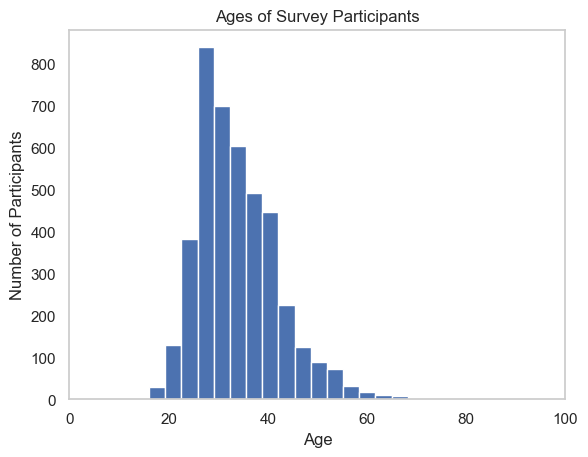

In [15]:
age_df["Age"][age_df["Age"] > 0].hist(grid=False, bins=100)

plt.Figure(figsize=(8, 8))
plt.xlim(0, 100)
plt.title("Ages of Survey Participants")
plt.xlabel("Age")
plt.ylabel("Number of Participants");

__Boxplot to better see outliers and quantiles__

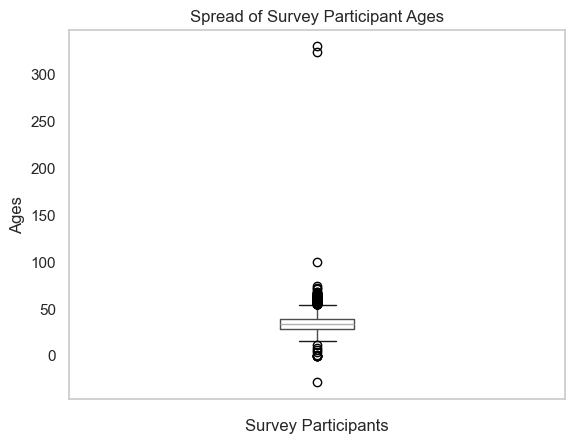

In [16]:
fig, ax = plt.subplots()
age_df.boxplot(column="Age", ax=ax)
ax.set_title("Spread of Survey Participant Ages")

ax.set_xlabel("Survey Participants")
ax.set_xticklabels([""])
ax.set_ylabel("Ages")
ax.grid(False)

plt.show()

Clearly there are plenty of outliers and false values for age such as seen below. 

In [17]:
max_age_query = """
            WITH age AS (
            SELECT q.questiontext, CAST(a.AnswerText AS INTEGER) as Age
            FROM Question q
            JOIN Answer a
            ON q.questionid = a.QuestionID
            WHERE a.QuestionID = 1)
            SELECT MAX(Age) as Maximum_Age
            FROM age
            """
max_age_df = query_to_df(max_age_query)
max_age_df

,Maximum_Age
0,329


So let's take a look only at ages 18-80 years old

In [18]:
age_subset_query = """
                   SELECT q.questiontext, CAST(a.AnswerText AS INTEGER) as Age
                   FROM Question q
                   JOIN Answer a
                   ON q.questionid = a.QuestionID
                   WHERE a.QuestionID = 1 AND Age BETWEEN 18 AND 80
                   """
age_subset_df = query_to_df(age_subset_query)
age_subset_df

,questiontext,Age
0,What is your age?,18
1,What is your age?,18
2,What is your age?,18
3,What is your age?,18
4,What is your age?,18
...,...,...
4197,What is your age?,67
4198,What is your age?,67
4199,What is your age?,70
4200,What is your age?,72


__Distribution of ages in the survey -- outliers removed__

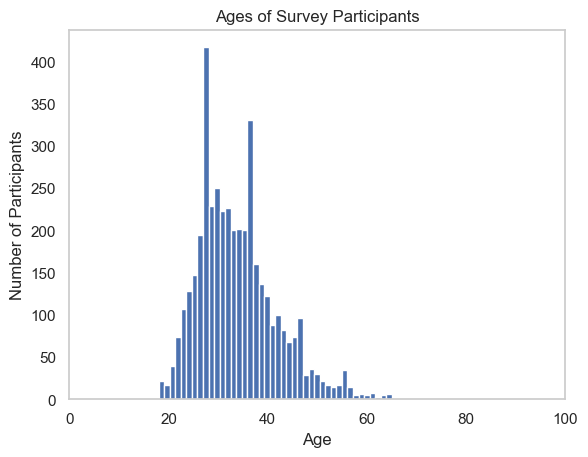

In [19]:
plt.Figure(figsize=(8, 8))

age_subset_df["Age"][age_df["Age"] > 0].hist(grid=False, bins=50)

plt.xlim(0, 100)
plt.title("Ages of Survey Participants")
plt.xlabel("Age")
plt.ylabel("Number of Participants");

__Boxplot to better see outliers and quantiles__

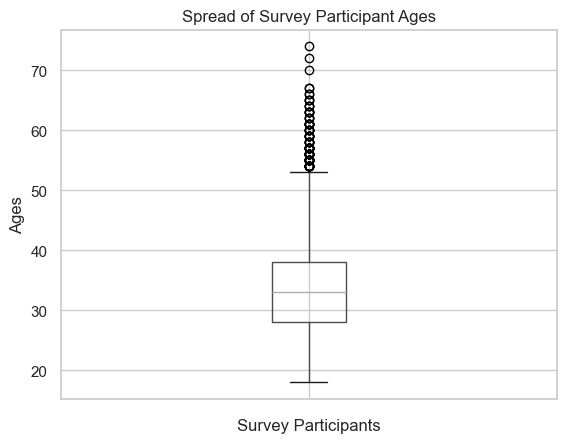

In [20]:
fig, ax = plt.subplots()
age_subset_df.boxplot(column="Age", ax=ax)
ax.set_title("Spread of Survey Participant Ages")

ax.set_xlabel("Survey Participants")
ax.set_xticklabels([""])
ax.set_ylabel("Ages")
ax.grid(True)

plt.show()

__Where in the world are the participants?__

In [21]:
country_count_query = """
                      SELECT AnswerText as country, COUNT(*) as num_employees
                      FROM Answer
                      GROUP BY AnswerText
                      HAVING QuestionID IN (3, 50)
                      ORDER BY COUNT(*) DESC
                      """
country_count_df = query_to_df(country_count_query)
country_count_df.replace({"United States of America": "United States"}, inplace=True)
country_count_df = (
    country_count_df.groupby("country")
    .sum()
    .sort_values(by="num_employees", ascending=False)
)
country_count_df

,num_employees
country,
United States,4476
United Kingdom,782
Canada,321
Germany,226
Netherlands,168
...,...
Swaziland,1
Thailand,1
Taiwan,1


this is too many countries to visualize in a bar chart<br>
__how many have > 50 employees?__

In [22]:
country_count_df[country_count_df["num_employees"] > 50].count()

num_employees    12
dtype: int64

In [23]:
top10countries = country_count_df.iloc[0:10]
top10countries

,num_employees
country,
United States,4476
United Kingdom,782
Canada,321
Germany,226
Netherlands,168
Australia,123
India,89
Georgia,87
France,85


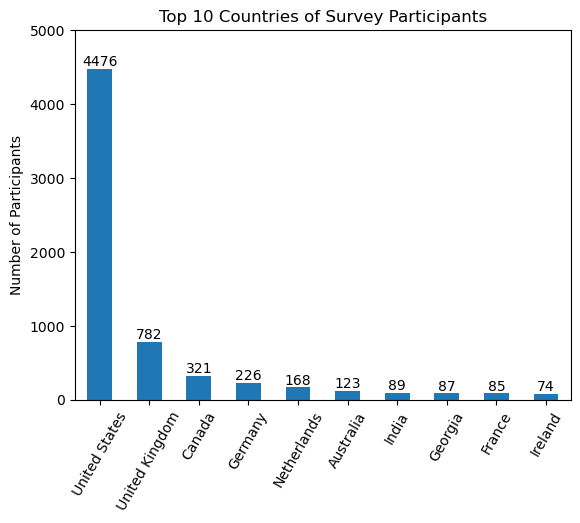

In [49]:
fig, ax = plt.subplots()

top10countries.plot(kind="bar", legend=False, ax=ax)
plt.title("Top 10 Countries of Survey Participants")
plt.xlabel(None)
plt.ylabel("Number of Participants")
plt.xticks(rotation=60)
ax.bar_label(ax.containers[0])
ax.set_ylim([0, 5000]);

__What US states are the participants in?__

In [24]:
state_count_query = """
                    SELECT AnswerText as country, COUNT(*) as num_employees
                    FROM Answer
                    GROUP BY AnswerText
                    HAVING QuestionID IN (4, 51)
                    ORDER BY COUNT(*) 
                    """
state_count_df = query_to_df(state_count_query)

state_count_df.set_index("country", inplace=True)

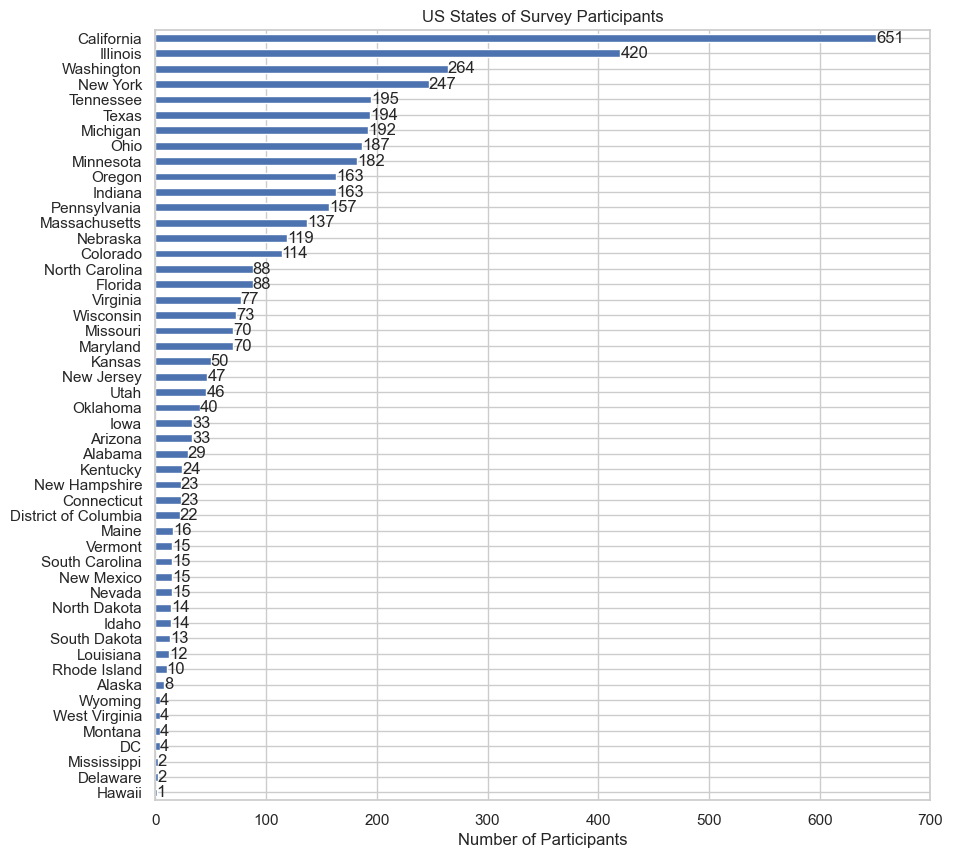

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

state_count_df.plot(kind="barh", legend=False, ax=ax)
plt.title("US States of Survey Participants")
plt.xlabel("Number of Participants")
plt.ylabel(None)
ax.bar_label(ax.containers[0])
ax.set_xlim([0, 700]);

***
## Employment Demographics 
What do survey participants state about their employment? 

I noticed that some workers may not be tech workers --<br>
__How many workers state that they work for a tech company in this survey?__

In [26]:
tech_workers_query = """
                     SELECT AnswerText AS tech_worker, 
                            COUNT(*) AS num_participants
                     FROM Answer
                     WHERE QuestionID = 9 
                     GROUP BY tech_worker
                     """

tech_workers_df = query_to_df(tech_workers_query)
tech_workers_df.replace({"-1": "No Answer", "0": "No", "1": "Yes"}, inplace=True)
tech_workers_df.set_index("tech_worker", inplace=True)

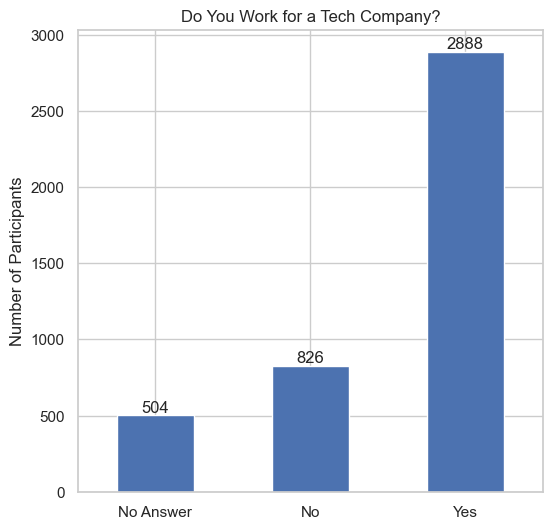

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
tech_workers_df.plot(kind="bar", legend=False, ax=ax)
plt.title("Do You Work for a Tech Company?")
plt.xlabel(None)
plt.ylabel("Number of Participants")
plt.xticks(rotation=0)
ax.bar_label(ax.containers[0]);

remote work has become much more prevalent in recent years --<br>
__who works from home?__

In [28]:
remote_work_query = """
                     SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID, a.UserID
                     FROM Question q
                     JOIN Answer a
                     ON q.questionid = a.QuestionID
                     WHERE q.questionid IN (93, 118)
                    """

remote_work_df = query_to_df(remote_work_query)
remote_work_df

,questiontext,questionid,AnswerText,SurveyID,UserID
0,Do you work remotely (outside of an office) at...,93,No,2014,1
1,Do you work remotely (outside of an office) at...,93,No,2014,2
2,Do you work remotely (outside of an office) at...,93,No,2014,3
3,Do you work remotely (outside of an office) at...,93,No,2014,4
4,Do you work remotely (outside of an office) at...,93,No,2014,6
...,...,...,...,...,...
2688,Do you work remotely?,118,Sometimes,2016,2689
2689,Do you work remotely?,118,Sometimes,2016,2690
2690,Do you work remotely?,118,Sometimes,2016,2691
2691,Do you work remotely?,118,Sometimes,2016,2692


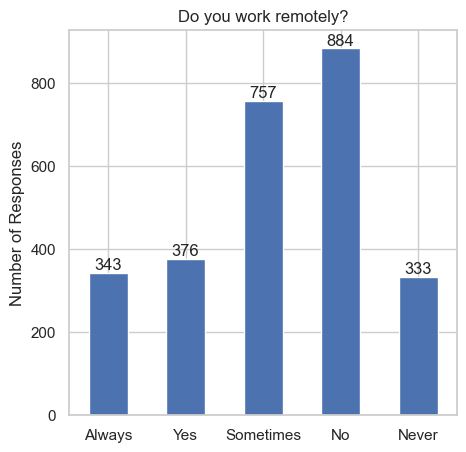

In [29]:
working_remote = remote_work_df["AnswerText"].value_counts()
ax = working_remote[["Always", "Yes", "Sometimes", "No", "Never"]].plot(
    kind="bar", figsize=(5, 5), xlabel="", rot=0, ylabel="Number of Responses"
)
plt.title("Do you work remotely?")
ax.bar_label(ax.containers[0]);

__How was remote work changing from 2014 to 2016?__

In [30]:
remote_work_annual_query = """
                           SELECT AnswerText as remote_work, SurveyID as year, COUNT(*) as num_responses
                           FROM Answer
                           WHERE QuestionID IN (93, 118)
                           GROUP BY year, remote_work
                           """

remote_work_annual_df = query_to_df(remote_work_annual_query)
remote_work_annual_df.replace(
    {"Never": "No", "Always": "Yes", "Sometimes": "Yes"}, inplace=True
)
remote_work_annual_df = (
    remote_work_annual_df.set_index(["remote_work", "year"])
    .groupby(["year", "remote_work"])
    .sum()
)
remote_work_annual_df.loc[(2014, "Total"), :] = remote_work_annual_df.loc[2014].sum()
remote_work_annual_df.loc[(2016, "Total"), :] = remote_work_annual_df.loc[2016].sum()
remote_work_annual_df.loc[(2014, "Yes%"), :] = (
    remote_work_annual_df.loc[(2014, "Yes"), :]
    / remote_work_annual_df.loc[(2014, "Total"), :]
) * 100
remote_work_annual_df.loc[(2016, "Yes%"), :] = (
    remote_work_annual_df.loc[(2016, "Yes"), :]
    / remote_work_annual_df.loc[(2016, "Total"), :]
) * 100

remote_percent_df = remote_work_annual_df[
    remote_work_annual_df.index.get_level_values("remote_work") == "Yes%"
]

remote_percent_df

,,num_responses
year,remote_work,
2014,Yes%,29.841270
2016,Yes%,76.762038


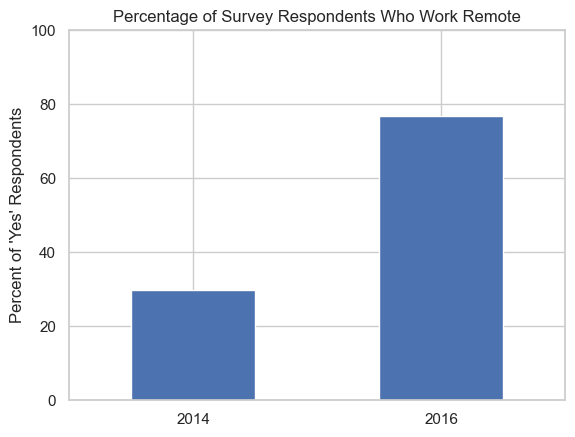

In [31]:
fig, ax = plt.subplots()

remote_percent_df.plot(
    kind="bar",
    ax=ax,
    legend=False,
    rot=0,
    xlabel="",
    ylabel="Percent of 'Yes' Respondents",
    title="Percentage of Survey Respondents Who Work Remote",
    ylim=[0, 100],
)

ax.set_xticklabels(["2014", "2016"]);

__who is self employed?__

In [32]:
self_employed_query = """
                      SELECT SurveyID AS year, AnswerText as answer, COUNT(*) as num_responses
                      FROM Answer
                      WHERE QuestionID IN (5) 
                      GROUP BY year, answer
                      HAVING answer = '1'
                      """

self_employed_df = query_to_df(self_employed_query)
self_employed_df

,year,answer,num_responses
0,2014,1,146
1,2016,1,287
2,2017,1,113
3,2018,1,56
4,2019,1,48


__Is there any trend in self-employment across the years?__

In [33]:
self_employed_query = """
                      WITH yes_responses AS (
                      SELECT SurveyID AS year, AnswerText as answer, COUNT(*) AS yes_responses
                      FROM Answer
                      WHERE QuestionID IN (5) 
                      GROUP BY year, answer
                      HAVING answer = '1'
                      ), 
                      totals AS (SELECT SurveyID AS year, COUNT(*) AS annual_totals
                      FROM Answer
                      WHERE QuestionID IN (5) 
                      GROUP BY year)
                      SELECT y.year as year, (y.yes_responses * 100.0 / t.annual_totals) as yes_percentages
                      FROM yes_responses y 
                      JOIN totals t
                      ON y.year = t.year
                      """

self_employed_df = query_to_df(self_employed_query)
self_employed_df

,year,yes_percentages
0,2014,11.587302
1,2016,20.027913
2,2017,14.947090
3,2018,13.429257
4,2019,13.636364


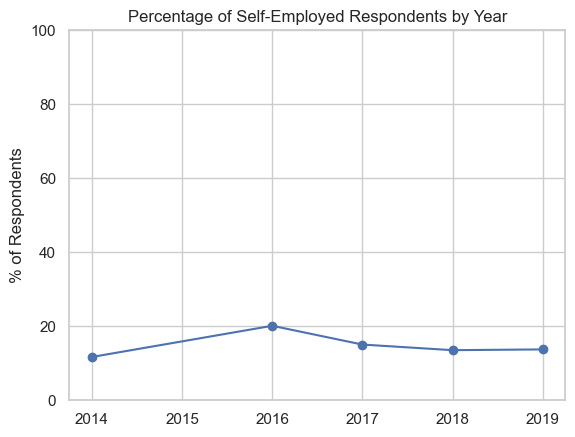

In [34]:
ax = self_employed_df.plot(
    x="year",
    y="yes_percentages",
    kind="line",
    title="Percentage of Self-Employed Respondents by Year",
    legend=False,
    ylim=(0, 100),
    rot=0,
    xlabel="",
    ylabel="% of Respondents",
)

ax.scatter(self_employed_df["year"], self_employed_df["yes_percentages"])

plt.show()

***
## Mental Health Statistics
For the remainder of this notebook I will focus on the primary content of the survey, mental health and approach basic statistical analyses. 

Again, a reminder of my approach -- here are some questions I found relevant

In [35]:
mental_health_disorder_question_query = """
                                        SELECT questiontext, questionid
                                        FROM Question 
                                        WHERE questiontext IN ('Have you ever sought treatment for a mental health disorder from a mental health professional?',
                                                                'Have you had a mental health disorder in the past?',
                                                                'Do you currently have a mental health disorder?',
                                                                'Have you ever been diagnosed with a mental health disorder?',
                                                                'If yes, what condition(s) have you been diagnosed with?',
                                                                'If maybe, what condition(s) do you believe you have?')
                                        """

query_to_df(mental_health_disorder_question_query)

,questiontext,questionid
0,Have you ever sought treatment for a mental he...,7
1,Have you had a mental health disorder in the p...,32
2,Do you currently have a mental health disorder?,33
3,Have you ever been diagnosed with a mental hea...,34
4,"If yes, what condition(s) have you been diagno...",115
5,"If maybe, what condition(s) do you believe you...",116


this is a more robust approach to find questions about "mental health disorders"

In [36]:
mental_health_disorder_wildcard_query = """
                                        SELECT questiontext, questionid
                                        FROM Question 
                                        WHERE questiontext LIKE '%mental health disorder%'
                                        LIMIT 5
                                        """

query_to_df(mental_health_disorder_wildcard_query)

,questiontext,questionid
0,Have you ever sought treatment for a mental he...,7
1,Does your employer offer resources to learn mo...,16
2,Do you have medical coverage (private insuranc...,20
3,Did your previous employers provide resources ...,26
4,Have your observations of how another individu...,31


In [38]:
diagnosis_mapping = {
    "ADD (w/o Hyperactivity)": "ADD/ADHD",
    "Anxiety Disorder (Generalized, Social, Phobia, etc)": "Anxiety",
    "Autism": "Autism Spectrum",
    "Autism (Asperger's)": "Autism Spectrum",
    "Autism spectrum disorder": "Autism Spectrum",
    "Burn out": "Burnout",
    'Combination of physical impairment (strongly near-sighted) with a possibly mental one (MCD / "ADHD", though its actually a stimulus filtering impairment)': "ADD/ADHD",
    "Depression": "Depression",
    "Dissociative Disorder": "Dissociative Disorder",
    "Eating Disorder (Anorexia, Bulimia, etc)": "Eating Disorder",
    "Gender Dysphoria": "Gender Dysphoria",
    "Mood Disorder (Depression, Bipolar Disorder, etc)": "Depression",
    "PDD-NOS": "PDD-NOS",
    "PTSD (undiagnosed)": "PTSD",
    "Personality Disorder (Borderline, Antisocial, Paranoid, etc)": "Personality Disorder",
    "Pervasive Developmental Disorder (Not Otherwise Specified)": "PDD-NOS",
    "PDD:NOS": "PDD-NOS",
    "Post-traumatic Stress Disorder": "PTSD",
    "Sexual addiction": "Sexual Addiction/Intimacy Disorder",
    "Sleeping Disorder": "Sleep Disorder",
    "Stress Response Syndromes": "Stress Response Syndrome",
    "Substance Use Disorder": "Substance Use/Addiction",
    "Transgender": "Gender Dysphoria",
    "Addictive Disorder": "Substance Use/Addiction",
    "Attention Deficit Hyperactivity Disorder": "ADD/ADHD",
    "Intimate Disorder": "Sexual Addiction/Intimacy Disorder",
    "Obsessive-Compulsive Disorder": "OCD",
    "Psychotic Disorder (Schizophrenia, Schizoaffective, etc)": "Psychotic Disorder",
    "I haven't been formally diagnosed, so I felt uncomfortable answering, but Social Anxiety and Depression.": "Depression",
    "Autism Spectrum Disorder": "Austism Spectrum",
    "Schizotypal Personality Disorder": "Psychotic Disorder",
    "Asperges": "Autism Spectrum",
    "Seasonal Affective Disorder": "Seasonal Affective Disorder",
    "Traumatic Brain Injury": "Traumatic Brain Injury",
}

__What mental conditions do survey respondents state that they have?__

In [39]:
conditions_query = """
                   SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID
                   FROM Question q
                   JOIN Answer a
                   ON q.questionid = a.QuestionID
                   WHERE q.questionid = 115
                   """

conditions_df = query_to_df(conditions_query)
conditions_df

,questiontext,questionid,AnswerText,SurveyID
0,"If yes, what condition(s) have you been diagno...",115,-1,2016
1,"If yes, what condition(s) have you been diagno...",115,-1,2016
2,"If yes, what condition(s) have you been diagno...",115,-1,2016
3,"If yes, what condition(s) have you been diagno...",115,-1,2016
4,"If yes, what condition(s) have you been diagno...",115,-1,2016
...,...,...,...,...
2067,"If yes, what condition(s) have you been diagno...",115,Substance Use Disorder,2016
2068,"If yes, what condition(s) have you been diagno...",115,Substance Use Disorder,2016
2069,"If yes, what condition(s) have you been diagno...",115,Substance Use Disorder,2016
2070,"If yes, what condition(s) have you been diagno...",115,Transgender,2016


Limiting our query to just those who work at tech companies, what mental conditions do survey respondents share?

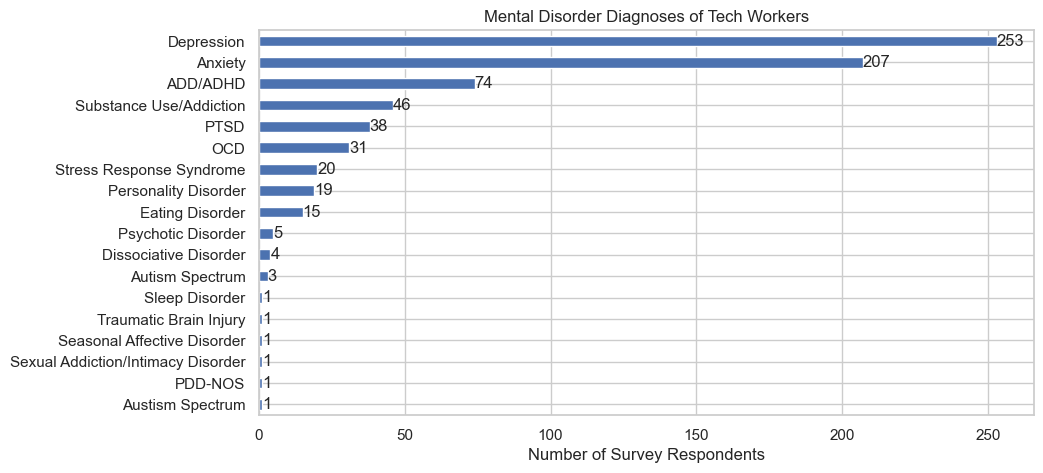

In [40]:

conditions_in_tech_query = """WITH tech_workers AS 
                              (SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID, a.UserID
                               FROM Question q
                               JOIN Answer a
                               ON q.questionid = a.QuestionID
                               WHERE (q.questionid = 9 AND a.AnswerText = 1)
                               )
                                SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID
                                FROM Question q
                                JOIN Answer a
                                ON q.questionid = a.QuestionID
                                JOIN tech_workers t
                                ON a.UserID = t.UserID
                                WHERE q.questionid = 115
                                """

conditions_in_tech_df = query_to_df(conditions_in_tech_query)
conditions_in_tech_df.replace(diagnosis_mapping, inplace=True)
conditions_in_tech = conditions_in_tech_df.AnswerText.value_counts(ascending=True)
conditions_in_tech = conditions_in_tech.drop(labels="-1")
ax = conditions_in_tech.plot(
    kind="barh",
    figsize=(10, 5),
    title="Mental Disorder Diagnoses of Tech Workers",
    ylabel="",
    xlabel="Number of Survey Respondents",
)
ax.bar_label(ax.containers[0])
plt.show()

Although this data comes from before the large increase in remote working,
I am curious is there is any trend between remote working and mental health diagnoses<br>
Do remote workers or non-remote workers have more current disorders?

In [41]:
remote_disorders_query = """
        WITH remote_workers AS
        (SELECT *
         FROM Answer a
         JOIN Question q
         ON a.QuestionID = q.questionid
         WHERE a.QuestionID IN (93, 118)
        ) 
        SELECT r.AnswerText as remote, a.AnswerText as current_disorder
        FROM Answer a
        JOIN remote_workers r
        ON a.UserID = r.UserID
        WHERE a.QuestionID = 33
        """

remote_disorders_df = query_to_df(remote_disorders_query)
remote_disorders_df = remote_disorders_df.groupby("remote").value_counts()
remote_disorders_df = pd.DataFrame(remote_disorders_df)

remote_status = remote_disorders_df.index.get_level_values(level=0).unique()
disorder_status = remote_disorders_df.index.get_level_values(level=1).unique()

remote_status
for r_status in remote_status:
    remote_disorders_df.loc[(r_status, "Total"), :] = remote_disorders_df.loc[
        r_status
    ].sum()
    for d_status in disorder_status:
        remote_disorders_df.loc[(r_status, d_status), :] = (
            remote_disorders_df.loc[(r_status, d_status), :]
            / remote_disorders_df.loc[(r_status, "Total"), :]
        ) * 100

remote_disorder_percentages = remote_disorders_df.loc[
    (remote_status, disorder_status), :
]
remote_disorder_percentages = remote_disorder_percentages.reset_index()

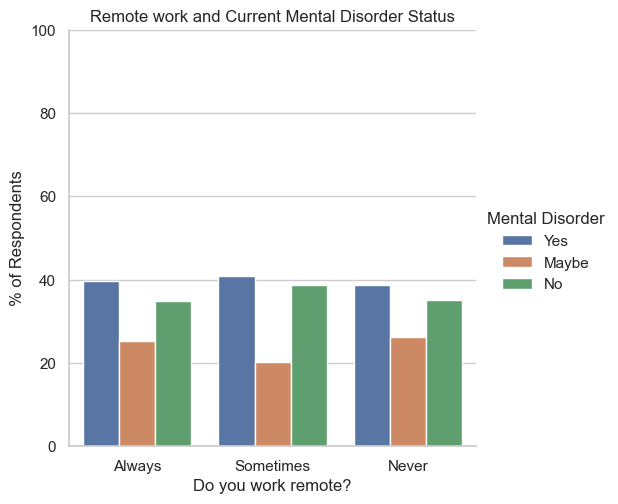

In [42]:
g = sns.catplot(
    x="remote",
    y="count",
    hue="current_disorder",
    data=remote_disorder_percentages,
    kind="bar",
    order=["Always", "Sometimes", "Never"],
    hue_order=["Yes", "Maybe", "No"],
)

plt.ylim(0, 100)
plt.xlabel("Do you work remote?")
plt.ylabel("% of Respondents")
plt.title("Remote work and Current Mental Disorder Status")

g._legend.set_title("Mental Disorder")

plt.show()

Considering just remote workers from the year 2016:<br>
__is there a relationship between mental health outcomes and remote work?__

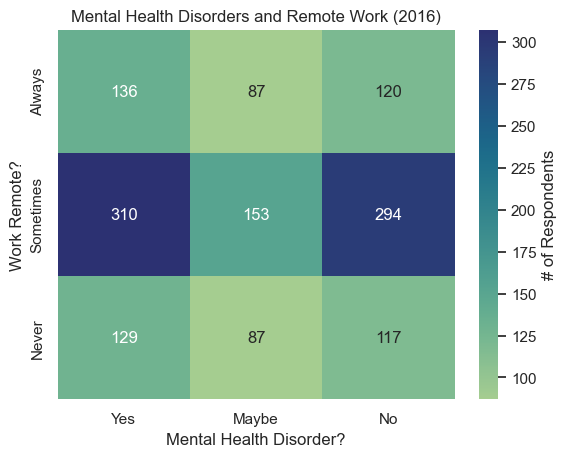

In [43]:
remote_mental_health_query2016 = """
                                 WITH remote_workers AS 
                                 (SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID, a.UserID
                                 FROM Question q
                                 JOIN Answer a
                                 ON q.questionid = a.QuestionID
                                 WHERE q.questionid IN (118)
                                 ),
                                 mental_health_2016 AS
                                 (SELECT q.questiontext, q.questionid, a.AnswerText, a.SurveyID, a.UserID
                                 FROM Question q
                                 JOIN Answer a
                                 ON q.questionid = a.QuestionID
                                 WHERE q.questionid IN (33) AND a.SurveyID = 2016)
                                 SELECT r.UserID AS user, r.AnswerText AS work_remote, m.AnswerText AS mental_health_disorder
                                 FROM remote_workers r
                                 JOIN mental_health_2016 m
                                 ON m.UserID = r.UserID
                                 """

remote_mental_health2016 = query_to_df(remote_mental_health_query2016)
remote_mental_health_table = remote_mental_health2016.groupby(
    by=["work_remote", "mental_health_disorder"]
).count()
remote_mental_health_table = remote_mental_health_table.reset_index()
remote_mental_health_pivot = remote_mental_health_table.pivot(
    index="work_remote", columns="mental_health_disorder", values="user"
)
remote_mental_health_pivot = remote_mental_health_pivot.reindex(
    ["Always", "Sometimes", "Never"], columns=["Yes", "Maybe", "No"]
)
sns.heatmap(
    data=remote_mental_health_pivot,
    cmap="crest",
    robust=True,
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "# of Respondents"},
)

plt.xlabel("Mental Health Disorder?")
plt.ylabel("Work Remote?")
plt.title("Mental Health Disorders and Remote Work (2016)")
plt.show()

#### Trends in Discussing Mental Health in the Workplace

with employer

In [44]:
discuss_query = """
                SELECT a.UserID, q.questiontext, a.Answertext, a.SurveyID, q.questionid
                FROM Question q
                JOIN Answer a
                ON a.QuestionID = q.questionid
                WHERE q.questionid IN (58, 70)
                """
discuss_df = query_to_df(discuss_query)

with pd.option_context("display.max_colwidth", 500):
    print(discuss_df["questiontext"].unique())

['Have you ever discussed your mental health with your employer?'
 'Did you ever discuss your mental health with your previous employer?']


In [45]:
employer_discuss_query = """
                         SELECT Answertext as employer_discuss, SurveyID as year, COUNT(*) as num_responses
                         FROM Answer
                         WHERE QuestionID IN (58, 70)
                         GROUP BY Answertext, SurveyID
                         """

employer_discuss_df = query_to_df(employer_discuss_query)
totals = employer_discuss_df.groupby("year")["num_responses"].sum()
years = employer_discuss_df.year.unique()
yes_employer = employer_discuss_df[employer_discuss_df["employer_discuss"] == "1"]
(
    yes_employer[yes_employer["year"] == 2017]["num_responses"].values / totals[2017]
) * 100
percentages = [
    (
        (
            yes_employer[yes_employer["year"] == year]["num_responses"].values
            / totals[year]
        )
        * 100
    )
    for year in years
]

with supervisor

In [46]:
discuss_query = """
                SELECT a.UserID, q.questiontext, a.Answertext, a.SurveyID, q.questionid
                FROM Question q
                JOIN Answer a
                ON a.QuestionID = q.questionid
                WHERE q.questionid IN (19, 28, 100)
                """
discuss_df = query_to_df(discuss_query)

with pd.option_context("display.max_colwidth", 500):
    print(discuss_df["questiontext"].unique())

['Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?'
 'Would you have been willing to discuss your mental health with your direct supervisor(s)?'
 'Would you be willing to discuss a mental health issue with your direct supervisor(s)?']


Discussing mental health with supervisor

In [47]:
supervisor_discuss_query = """
                SELECT a.UserID, q.questiontext, a.Answertext, a.SurveyID, q.questionid
                FROM Question q
                JOIN Answer a
                ON a.QuestionID = q.questionid
                WHERE q.questionid IN (19, 28, 100)
                """

supervisor_discuss_df = query_to_df(supervisor_discuss_query)
supervisor_discuss_counts = (
    supervisor_discuss_df[["SurveyID", "AnswerText"]]
    .groupby(["SurveyID"])
    .value_counts()
)
supervisor_discuss_counts = pd.DataFrame(supervisor_discuss_counts)

years = supervisor_discuss_counts.index.get_level_values(level=0).unique()
supervisor_discuss_percent = []
for year in years:
    supervisor_discuss_counts.loc[(year, "Total"), :] = supervisor_discuss_counts.loc[
        year
    ].sum()
    supervisor_discuss_counts.loc[(year, "Might"), :] = supervisor_discuss_counts.loc[
        (
            year,
            [
                "Yes",
                "Some of them",
                "Some of my previous employers",
                "Maybe",
                "Yes, at all of my previous employers",
                "Yes, all of my previous supervisors",
                "Some of my previous supervisors",
            ],
        ),
        :,
    ].sum()
    supervisor_discuss_counts.loc[(year, "Not"), :] = supervisor_discuss_counts.loc[
        (
            year,
            [
                "No",
                "No, at none of my previous employers",
                "No, none of my previous supervisors",
            ],
        ),
        :,
    ].sum()
    supervisor_discuss_counts.loc[(year, "Might%"), :] = (
        supervisor_discuss_counts.loc[(year, "Might"), :]
        / supervisor_discuss_counts.loc[(year, "Total"), :]
    ) * 100
    supervisor_discuss_counts.loc[(year, "Not%"), :] = (
        supervisor_discuss_counts.loc[(year, "Not"), :]
        / supervisor_discuss_counts.loc[(year, "Total"), :]
    ) * 100
    supervisor_discuss_percent.append(
        supervisor_discuss_counts.loc[(year, "Might%"), :]
    )

with coworker

In [48]:
discuss_query = """
                SELECT a.UserID, q.questiontext, a.Answertext, a.SurveyID, q.questionid
                FROM Question q
                JOIN Answer a
                ON a.QuestionID = q.questionid
                WHERE q.questionid IN (18, 60, 72, 99, 110)
                """
discuss_df = query_to_df(discuss_query)

with pd.option_context("display.max_colwidth", 500):
    print(discuss_df["questiontext"].unique())

['Would you feel comfortable discussing a mental health issue with your coworkers?'
 'Have you ever discussed your mental health with coworkers?'
 'Did you ever discuss your mental health with a previous coworker(s)?'
 'Would you be willing to discuss a mental health issue with your coworkers?'
 'Would you have been willing to discuss a mental health issue with your previous co-workers?']


Discussing mental health with coworker

In [49]:
coworker_discuss_query = """
                SELECT a.UserID, q.questiontext, a.Answertext, a.SurveyID, q.questionid
                FROM Question q
                JOIN Answer a
                ON a.QuestionID = q.questionid
                WHERE q.questionid IN (18, 60, 72, 99, 110)
                """

coworker_discuss_df = query_to_df(coworker_discuss_query)
coworker_discuss_df = query_to_df(coworker_discuss_query)
coworker_discuss_counts = (
    coworker_discuss_df[["SurveyID", "AnswerText"]].groupby(["SurveyID"]).value_counts()
)
coworker_discuss_counts = pd.DataFrame(coworker_discuss_counts)

years = coworker_discuss_counts.index.get_level_values(level=0).unique()
coworker_discuss_percent = []

for year in years:
    coworker_discuss_counts.loc[(year, "Total"), :] = coworker_discuss_counts.loc[
        year
    ].sum()
    coworker_discuss_counts.loc[(year, "Might"), :] = coworker_discuss_counts.loc[
        (
            year,
            [
                "Yes",
                "Some of them",
                "Some of my previous employers",
                "Maybe",
                "Yes, at all of my previous employers",
                "1",
            ],
        ),
        :,
    ].sum()
    coworker_discuss_counts.loc[(year, "Not"), :] = coworker_discuss_counts.loc[
        (year, ["No", "No, at none of my previous employers", "0"]), :
    ].sum()
    coworker_discuss_counts.loc[(year, "Might%"), :] = (
        coworker_discuss_counts.loc[(year, "Might"), :]
        / coworker_discuss_counts.loc[(year, "Total"), :]
    ) * 100
    coworker_discuss_counts.loc[(year, "Not%"), :] = (
        coworker_discuss_counts.loc[(year, "Not"), :]
        / coworker_discuss_counts.loc[(year, "Total"), :]
    ) * 100
    coworker_discuss_percent.append(coworker_discuss_counts.loc[(year, "Might%"), :])

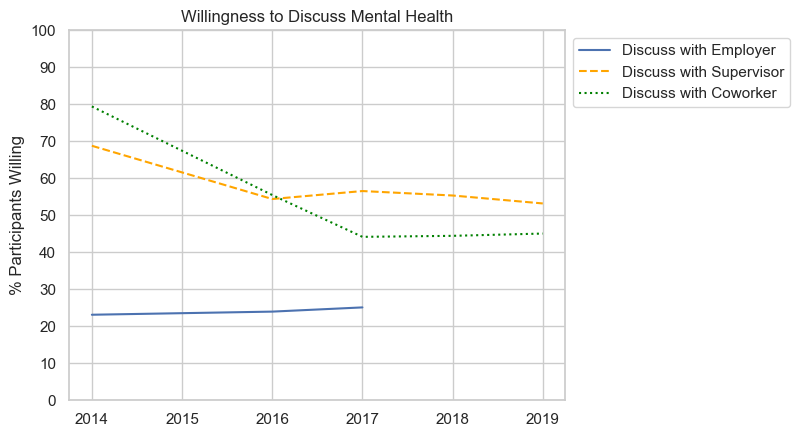

In [50]:
fig, ax = plt.subplots()
ax.plot(years[:3], percentages, label="Discuss with Employer")
ax.plot(
    years,
    supervisor_discuss_percent,
    label="Discuss with Supervisor",
    linestyle="--",
    color="orange",
)
ax.plot(
    years,
    coworker_discuss_percent,
    label="Discuss with Coworker",
    linestyle=":",
    color="green",
)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Setting the title and y-axis label
ax.set_title("Willingness to Discuss Mental Health")
ax.set_ylabel("% Participants Willing")
ax.set_ylim([0, 100])

# Adjusting tick positions
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

***
Mental Health Diagnoses By Tech Profession

In [51]:
jobs = [
    "Back-end Developer",
    "Front-end Developer",
    "Supervisor/Team Lead",
    "DevOps/SysAdmin",
    "Designer",
]

__Which mental health conditions correspond to different professions?__

In [52]:
diagnoses_by_job_query = """
        WITH positions AS
        (SELECT UserID, AnswerText as job, QuestionID
        FROM Answer
        WHERE QuestionID = 117
        ) 
        SELECT p.job, a.AnswerText as diagnosis, COUNT(*)
        FROM Answer a
        JOIN positions p 
        ON a.UserID = p.UserID 
        GROUP BY p.job, diagnosis
        HAVING a.QuestionID = 115 AND p.job IN ("Back-end Developer",
                                                "Front-end Developer",
                                                "Supervisor/Team Lead",
                                                "DevOps/SysAdmin",
                                                "Designer")        
        ORDER BY COUNT(*) DESC
        """

diagnoses_by_job_df = query_to_df(diagnoses_by_job_query)
diagnoses_by_job_df = diagnoses_by_job_df.groupby(["job", "diagnosis"]).sum("COUNT(*)")
diagnoses_by_job_df.reset_index()
jobs = diagnoses_by_job_df.index.get_level_values(level=0).unique()
diagnoses_by_job_df.rename(index=diagnosis_mapping, inplace=True)
diagnoses_by_job_df = diagnoses_by_job_df.groupby(["job", "diagnosis"]).sum("COUNT(*)")
diagnoses_by_job_df = diagnoses_by_job_df.reset_index()

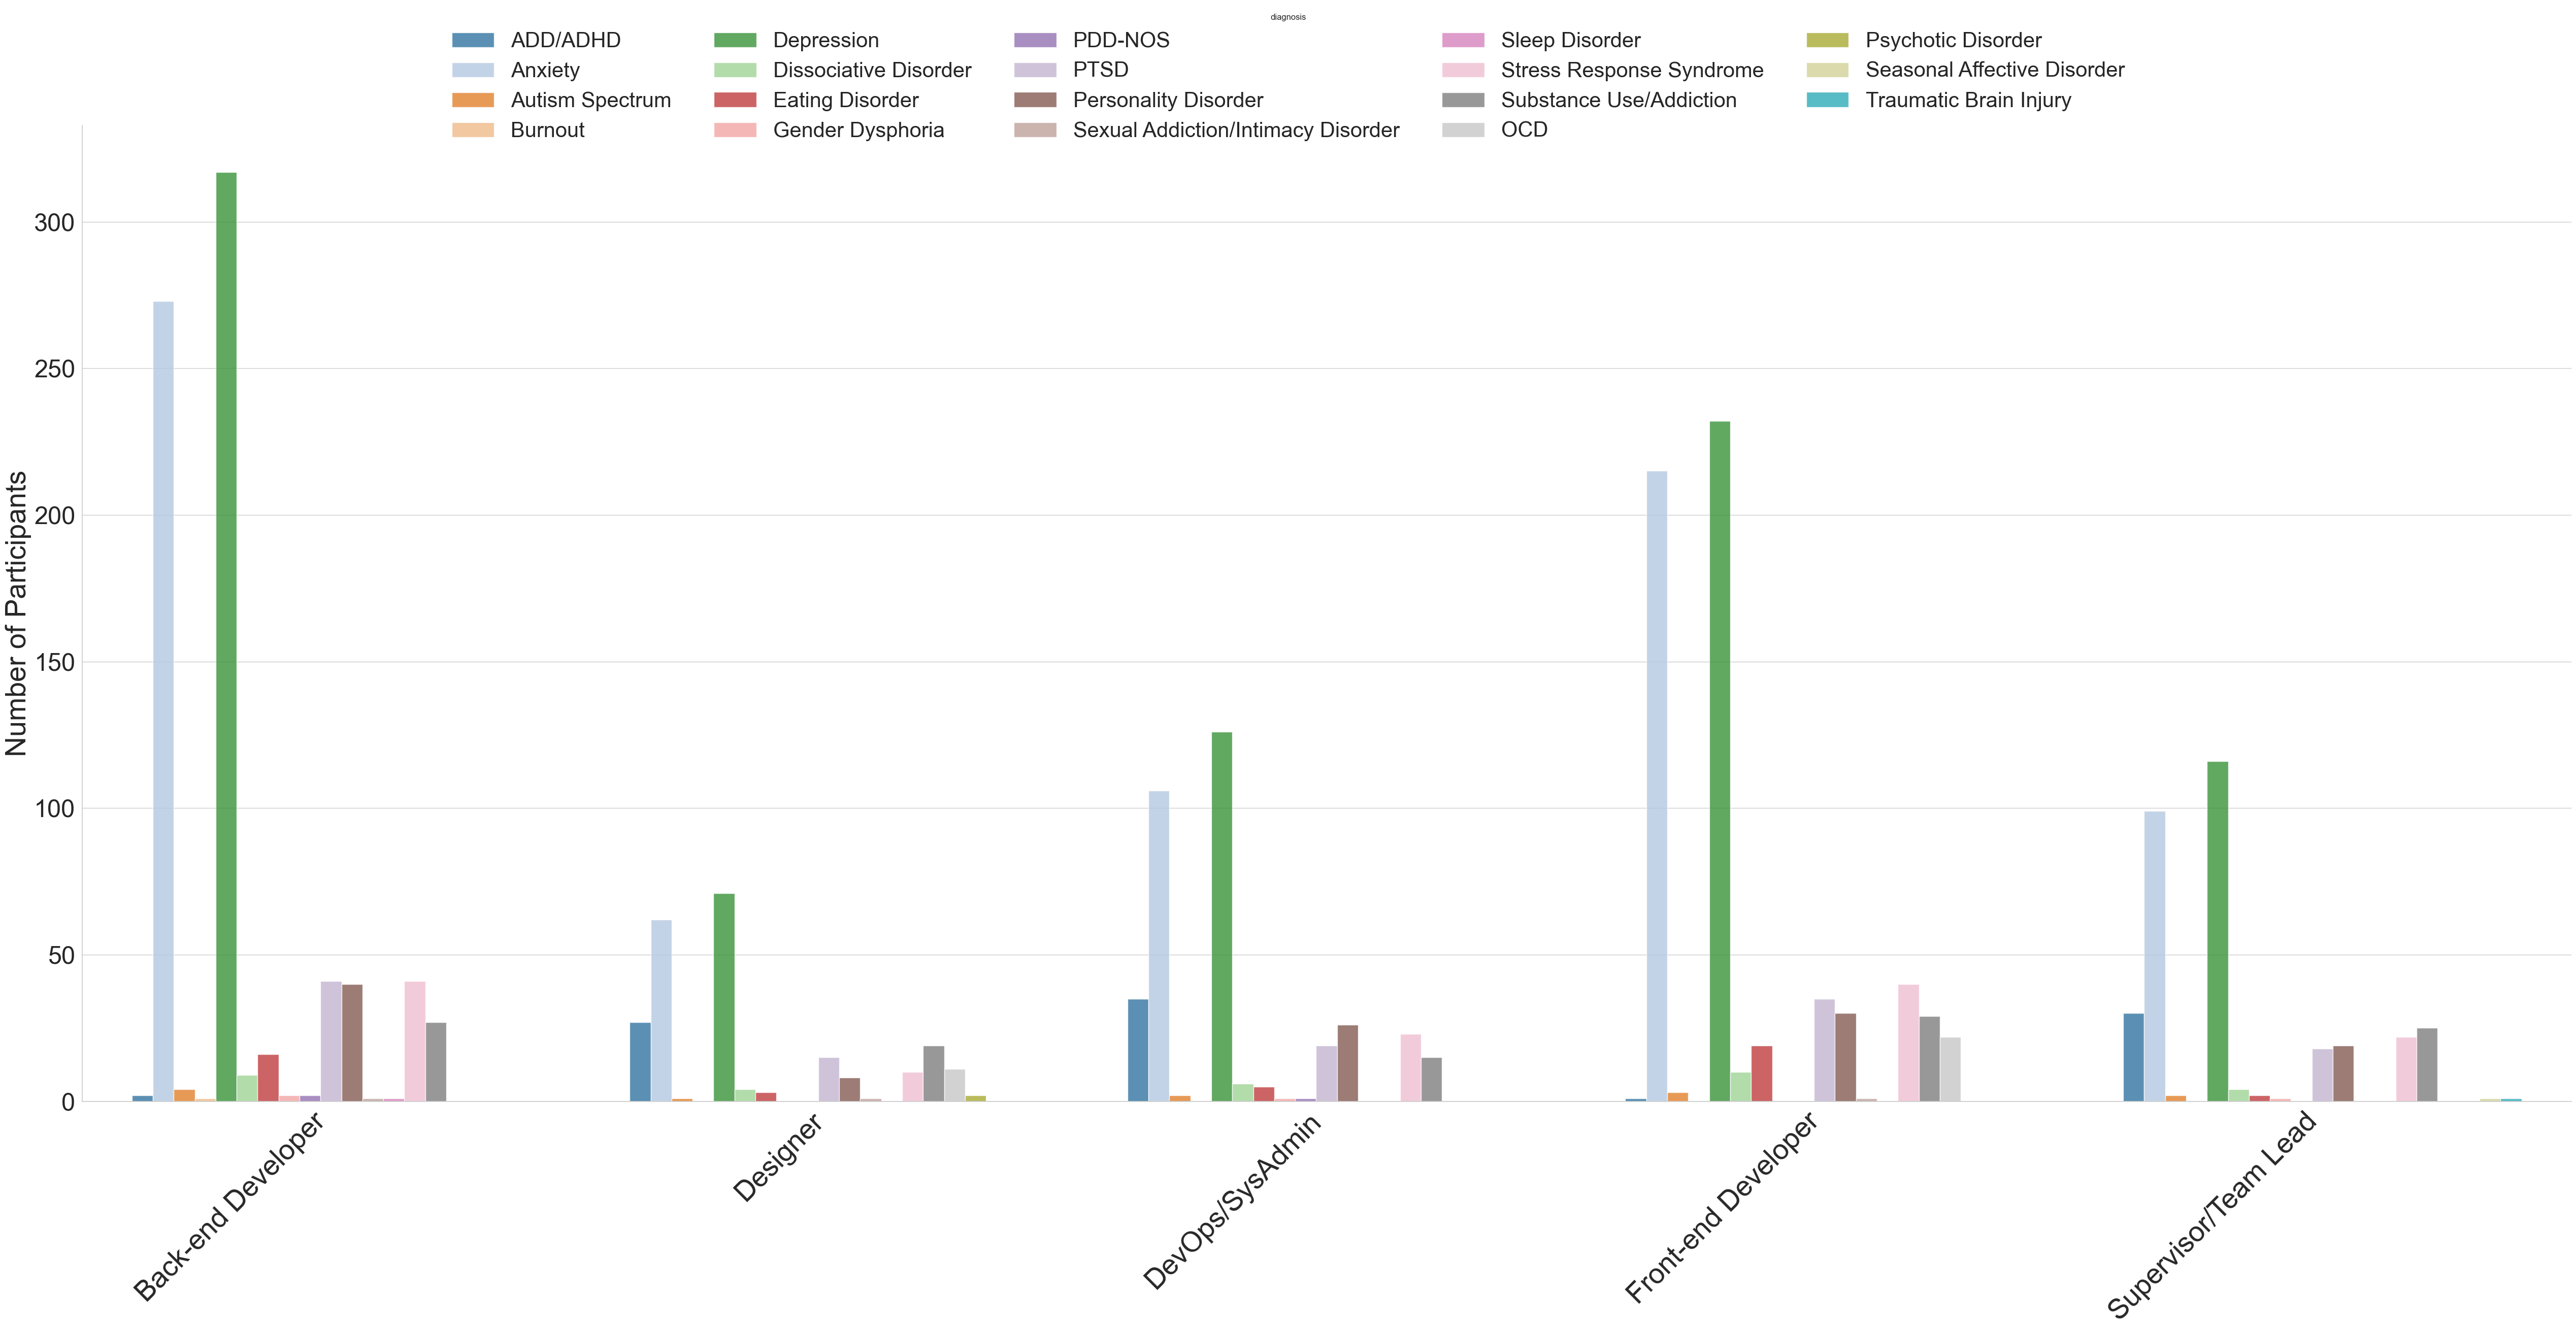

In [54]:
custom_palette = sns.color_palette("tab20", 19)

g = sns.catplot(
    data=diagnoses_by_job_df,
    kind="bar",
    x="job",
    y="COUNT(*)",
    hue="diagnosis",
    errorbar="sd",
    palette=custom_palette,
    alpha=0.8,
    height=24,
    aspect=2,
    order=jobs,
)

sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=30
)

g.set_xticklabels(rotation=45, ha="right", fontsize=40)

g.set(
    xlabel=None,
    ylabel="Number of Participants",
)
g.set_titles("Diagnoses by Tech Job", size=40)
g.set_axis_labels(None, "Number of Participants", fontsize=40)

g.ax.tick_params(axis='y', labelsize=35)

plt.tight_layout()

plt.show()

Normalized by Percentage Instead of looking at just numbers of Participants

In [55]:
diagnoses_by_job_query = """
        WITH positions AS
        (SELECT UserID, AnswerText as job, QuestionID
        FROM Answer
        WHERE QuestionID = 117
        ) 
        SELECT p.job, a.AnswerText as diagnosis, COUNT(*) as num_respondents
        FROM Answer a
        JOIN positions p 
        ON a.UserID = p.UserID 
        GROUP BY p.job, diagnosis
        HAVING a.QuestionID = 115 AND p.job IN ("Back-end Developer",
                                                "Front-end Developer",
                                                "Supervisor/Team Lead",
                                                "DevOps/SysAdmin",
                                                "Designer")        
        ORDER BY COUNT(*) DESC
        """
diagnoses_by_job_df = query_to_df(diagnoses_by_job_query)
diagnoses_by_job_df = diagnoses_by_job_df.groupby(["job", "diagnosis"]).sum(
    "num_respondents"
)
diagnoses_by_job_df
job_totals = diagnoses_by_job_df.groupby(level=0).sum()
job_totals
percent_diagnoses_by_job = diagnoses_by_job_df.div(job_totals, level=0) * 100
percent_diagnoses_by_job = percent_diagnoses_by_job.reset_index()
percent_diagnoses_by_job["diagnosis"] = percent_diagnoses_by_job["diagnosis"].map(
    diagnosis_mapping
)
percent_diagnoses_by_job = (
    percent_diagnoses_by_job.groupby(["job", "diagnosis"]).sum().reset_index()
)

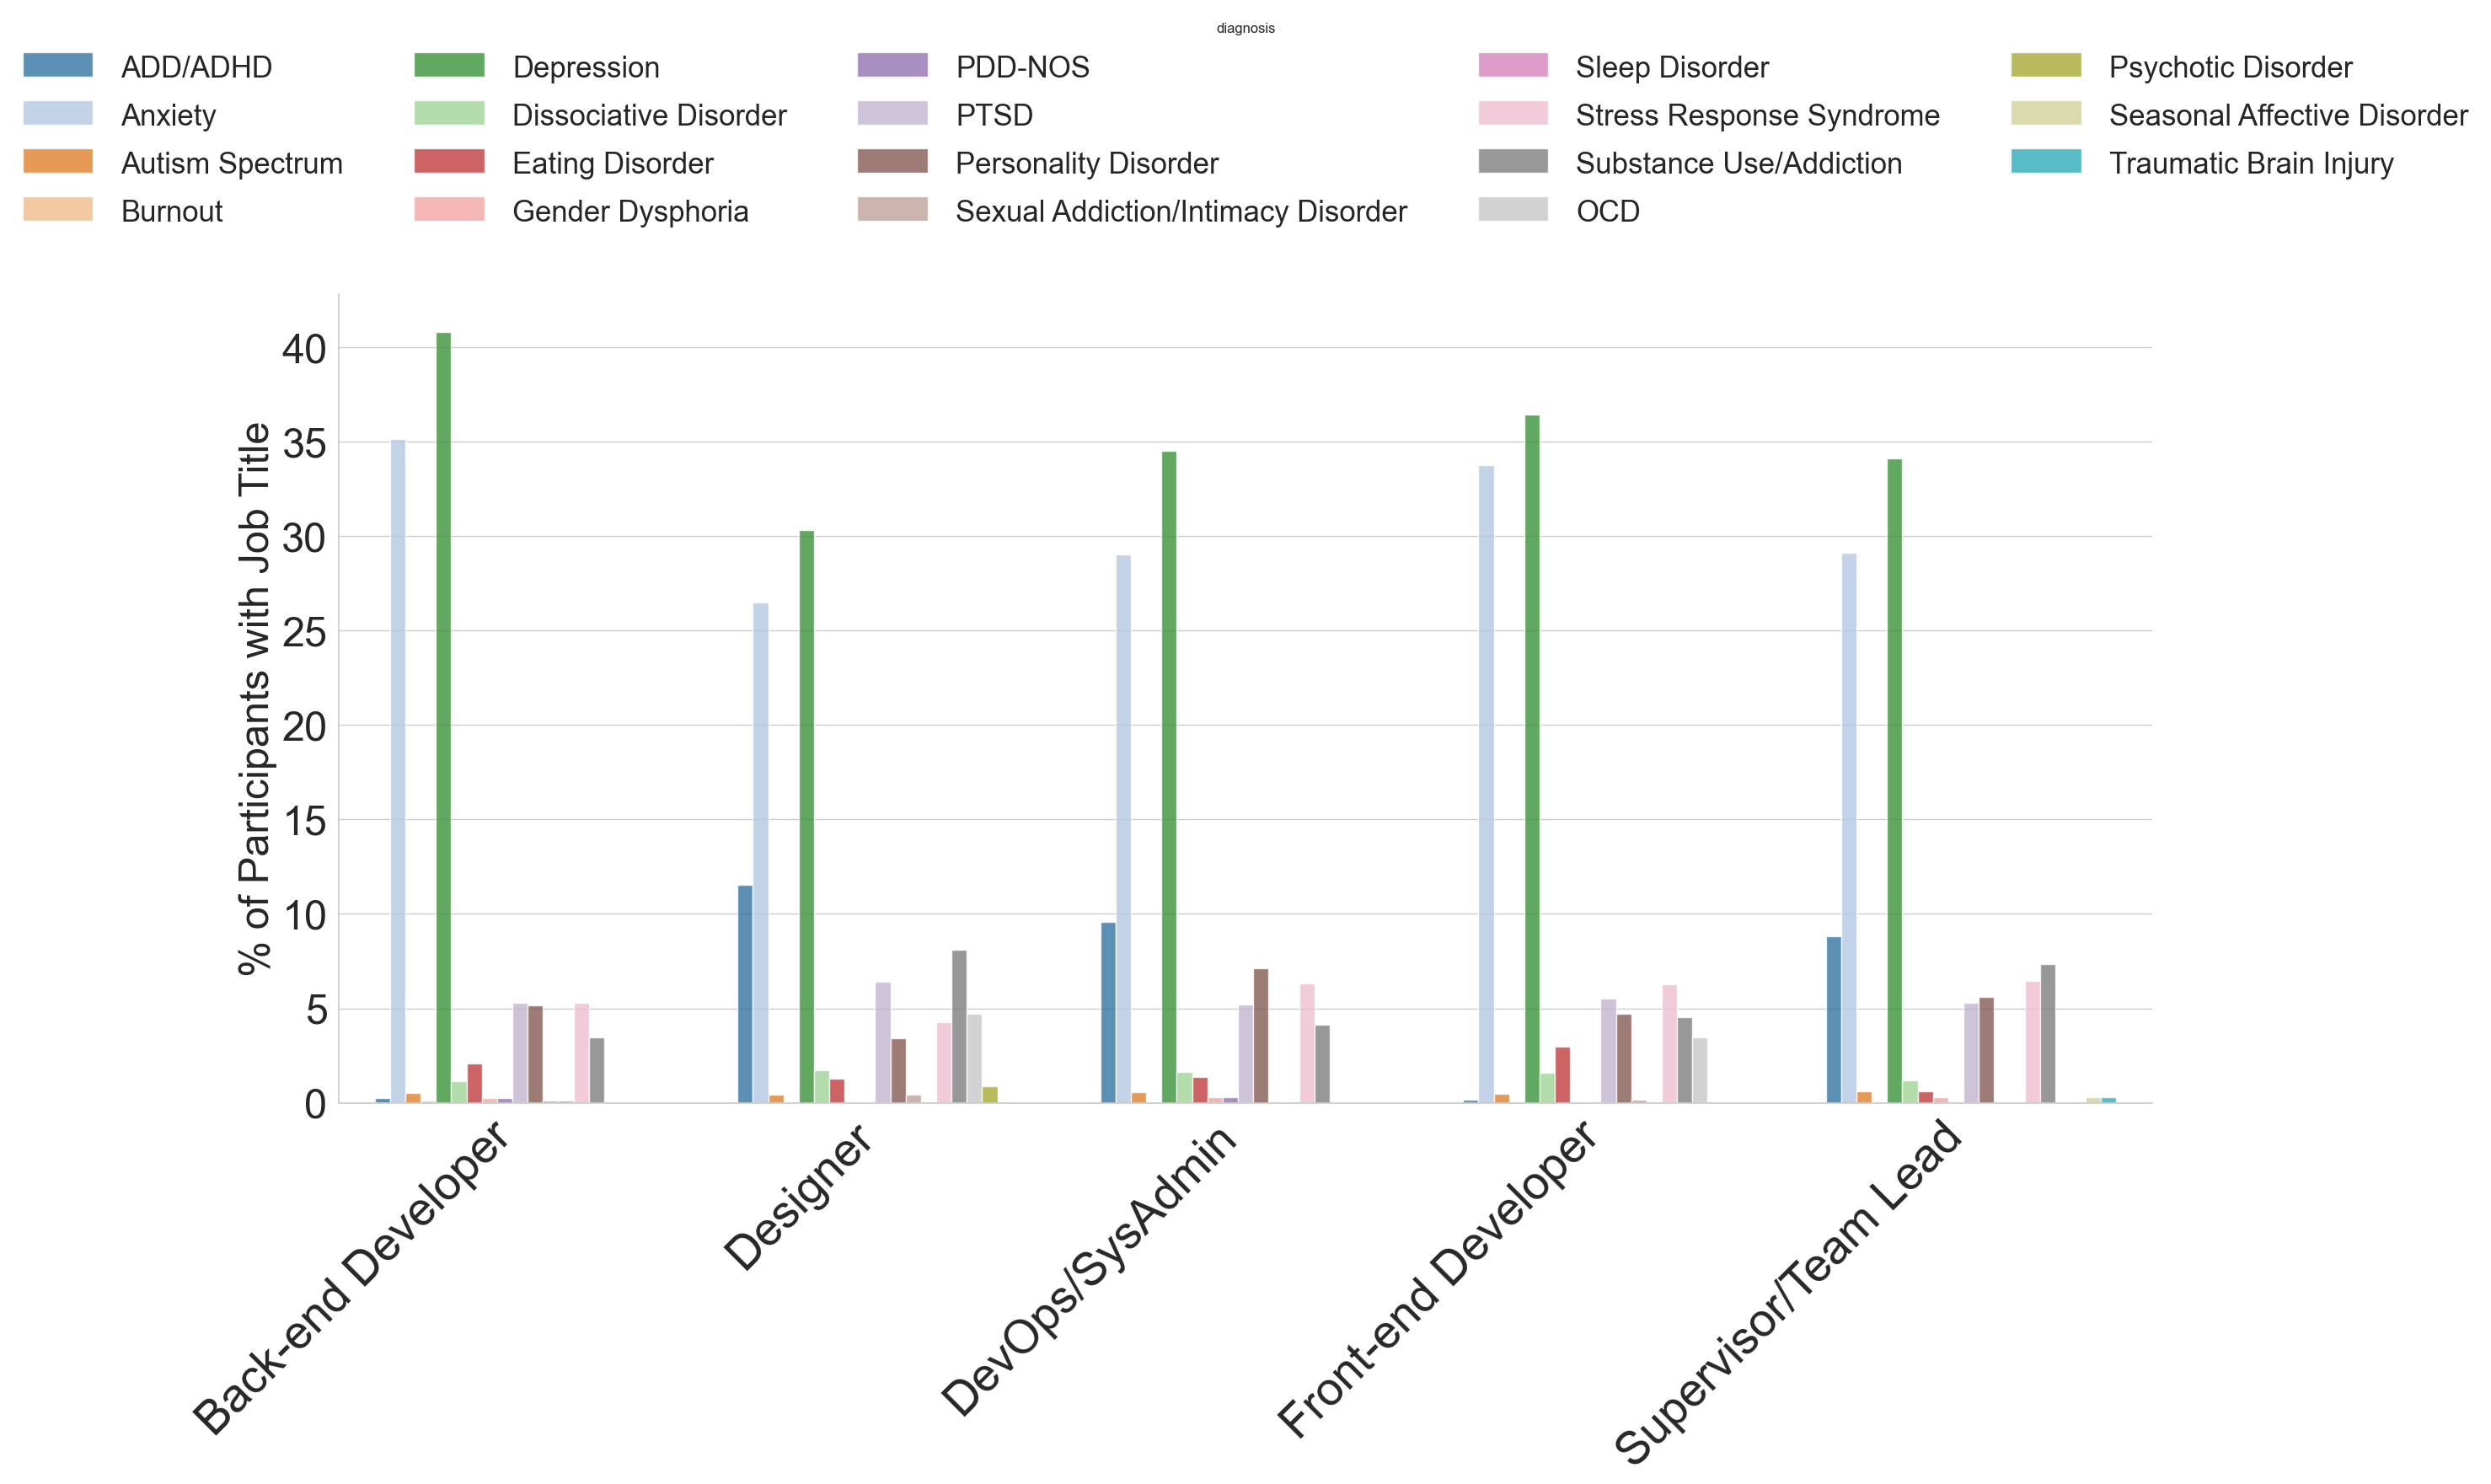

In [57]:
custom_palette = sns.color_palette("tab20", 19)

g = sns.catplot(
    data=percent_diagnoses_by_job,
    kind="bar",
    x="job",
    y="num_respondents",
    hue="diagnosis",
    errorbar="sd",
    palette=custom_palette,
    alpha=0.8,
    height=12,
    aspect=2,
    order=jobs,
)

sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=5, fontsize=30
)

g.set_xticklabels(rotation=45, ha="right", fontsize=40)

g.set(
    xlabel=None,
    ylabel="% of Participants with Job Title",
)

g.ax.tick_params(axis='y', labelsize=35)
g.ax.set_ylabel("% of Participants with Job Title", fontsize=35)

for text in g._legend.texts:
    text.set_fontsize(25)

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()

is there a correlation between having seen a negative experience of:
* badly handled mental health issue in the workplace, in general (question 56)
* negative consequences for a coworker open about mental health (question 105)
* perceptions of how easy/hard it is to ask for leave from their company (questions 17 & 97)

In [59]:
bad_experiences_query = """
        WITH bad_interaction AS (
        SELECT q.questiontext, q.questionid, a.AnswerText, a.UserID
        FROM Question q
        JOIN Answer a
        ON q.questionid = a.QuestionID
        WHERE q.questionid IN (56, 105) 
              AND a.AnswerText NOT IN ('-1', "I've always been self-employed", 'Maybe/Not sure', "I don't know", "Don't know")
        ), 
        company_leave AS (
        SELECT q.questiontext, q.questionid, a.AnswerText, a.UserID
        FROM Question q
        JOIN Answer a
        ON q.questionid = a.QuestionID
        WHERE q.questionid IN (17, 97) 
              AND a.AnswerText NOT IN ('-1', "I've always been self-employed", 'Maybe/Not sure', "I don't know", "Don't know")
        )
        SELECT b.AnswerText as seen_interaction, c.AnswerText as leave_difficulty
        FROM bad_interaction b
        JOIN company_leave c
        ON b.UserID = c.UserID
        """

answer_mapper = {
    "Difficult": 6,
    "Neither easy nor difficult": 4,
    "Somewhat difficult": 5,
    "Somewhat easy": 3,
    "Very difficult": 7,
    "Very easy": 1,
    "No": 0,
    "Yes, I experienced": 1,
    "Yes, I observed": 1,
    "Yes": 1,
}

pd.set_option('future.no_silent_downcasting', True)
bad_experiences_df = query_to_df(bad_experiences_query)
bad_experiences_df.replace(answer_mapper, inplace=True)
bad_experiences_df

,seen_interaction,leave_difficulty
0,0,1
1,0,3
2,0,3
3,0,5
4,0,1
...,...,...
2500,1,4
2501,1,7
2502,1,7
2503,1,3


In [60]:
bad_experiences_df["seen_interaction"] = bad_experiences_df["seen_interaction"].astype("boolean")
bad_experiences_df["leave_difficulty"] = bad_experiences_df["leave_difficulty"].astype("int")

we will observe correlations between perceived difficulty of leave and first hand experiences of bad interactions. Alpha-level = 0.05

In [61]:
correlation, p_value = pointbiserialr(
    bad_experiences_df["seen_interaction"], bad_experiences_df["leave_difficulty"]
)

print(f"Point-Biserial Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

Point-Biserial Correlation: 0.148
P-value: 0.000


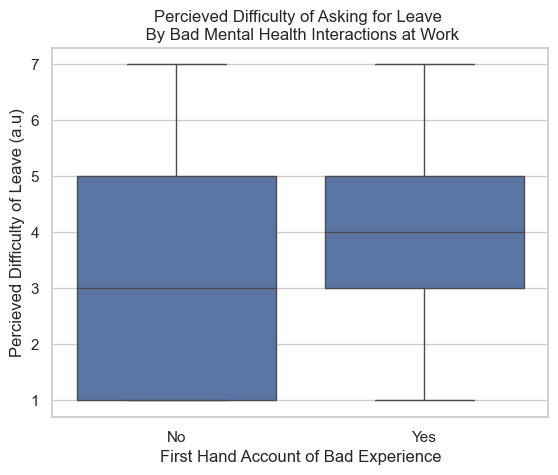

In [62]:
sns.boxplot(x="seen_interaction", y="leave_difficulty", data=bad_experiences_df)
plt.xlabel("First Hand Account of Bad Experience")
plt.ylabel("Percieved Difficulty of Leave (a.u)")
plt.title(
    "Percieved Difficulty of Asking for Leave \n By Bad Mental Health Interactions at Work"
)
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.show()

To further analyze these bad experiences statistically, I will:
* Perform an independent samples t-test to see if there is a significant difference between groups (alpha-level=0.05)
* Look at effect size using Cohen's d
* Observe the size of the mean difference between groups and look at the pooled standard deviation of the data

In [63]:
group1 = bad_experiences_df[bad_experiences_df["seen_interaction"] == 0][
    "leave_difficulty"
]
group2 = bad_experiences_df[bad_experiences_df["seen_interaction"] == 1][
    "leave_difficulty"
]

t_statistic, p_value = ttest_ind(group1, group2, equal_var=False)
mean_difference = group1.mean() - group2.mean()
pooled_std = ((len(group1) - 1) * group1.var() + (len(group2) - 1) * group2.var()) / (
    len(bad_experiences_df) - 2
)

cohen_d = mean_difference / (pooled_std**0.5)

print(f"Mean Difference: {mean_difference:.3f}")
print(f"Pooled Standard Deviation: {pooled_std:.3f}")
print(f"t-statistic: {t_statistic:.3f}, p=value: {p_value:.3f}")
print(f"Cohen's d: {np.abs(cohen_d):.3f}")

Mean Difference: -0.589
Pooled Standard Deviation: 3.154
t-statistic: -7.446, p=value: 0.000
Cohen's d: 0.331


Taken together
* it does appear that there is some effect (d=0.331)
* It does appear that those reporting bad mental health experiences might be those who find it more difficult to request leave from work (on average, as defined above)
* This is highlighted by the significant difference between those two groups on perceived difficulty to request leave with those who don't have a bad experience reporting it 0.589 survey units easier, on average. 

__Does size of company (question 8) correspond to whether it is easier or harder to ask for leave (questions 17, 97)?__

In [64]:
query = """
        WITH company_size AS (
        SELECT AnswerText, QuestionID, UserID
        FROM Answer
        WHERE QuestionID = 8 AND AnswerText NOT IN (-1)),
        leave_difficulty AS (
        SELECT AnswerText, QuestionID, UserID
        FROM Answer
        WHERE QuestionID IN (17, 97) AND AnswerText NOT IN (-1, "Don't know", "I don't know")
        )
        SELECT c.AnswerText as company_size, l.AnswerText as difficulty_asking_for_leave
        FROM company_size c
        JOIN leave_difficulty l 
        ON c.UserID = l.UserID
        """

query_df = query_to_df(query)

encoding_variable1 = {
    "1-5": 3,
    "6-25": 15.5,
    "26-100": 63,
    "100-500": 300,
    "500-1000": 750,
    "More than 1000": 1500,
}
query_df["company_size_encoded"] = query_df["company_size"].map(
    encoding_variable1)

encoding_variable2 = {
    "Very difficult": 1,
    "Difficult": 2,
    "Somewhat difficult": 3,
    "Neither easy nor difficult": 4,
    "Somewhat easy": 6,
    "Very easy": 7,
}
query_df["difficulty_asking_encoded"] = query_df["difficulty_asking_for_leave"].map(
    encoding_variable2
)


correlation, p_value = spearmanr(
    query_df["company_size_encoded"], query_df["difficulty_asking_encoded"]
)
print(
    f"""
    It does not appear that the difficulty of leave correlates to the size of the company. 
    Correlation: {correlation:.2f}, p-value: {p_value:.4f}
    """
)


    It does not appear that the difficulty of leave correlates to the size of the company. 
    Correlation: -0.02, p-value: 0.2233
    


***
# Conclusions 

This rudimentary analysis focused more on the technical goals of:
- working with SQL databases
- working with Pandas
- using Matplotlib and Seaborn to plot
than on the experimental question of "What is the culture of tech companies regarding mental health?"

More analyses of this dataset could provide clearer answers to that question. However, the technical goals were addressed effectively. 

As a technical note, we learned that the underlying PRAGMA table of this dataset did not have information about primary and foreign keys.

In terms of the content of the study:
- survey partipants had a median age around 34
- lived in the United States (however participants lived in many countries)
- not all participants worked in tech
- most did not work remote
- depression and anxiety were the highest reported mental disorders
- remote work did note correlate with mental disorder status
- many participants are willing to discuss mental health with coworkers and supervisors
- On average, those who have first hand accounts of bad experiences at work percieve leave from work to be more difficult to request
- Difficulty asking for leave from work did not correlate with the size of the company 